In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# I. About the dataset

We use the dataset **Energy balance matrix** from 1970 to 2021 of Brazil. The dataset is downloaded in the website of 
Olade.

The calculations for data processing base on the **Manual Olade 2011**

## I.1 Load the dataset

In [2]:
# Load the file
file_path = '../datas/Option_B/Brazil_Energy balance matrix.xlsx'
#File excel with multi-sheet_names is read as an Dictionary
Dict = pd.read_excel(file_path, sheet_name=None, skiprows=range(4), skipfooter=3)


# Create a new dictionary to store modified dataframes
modified_dict = {}

for k, df in Dict.items():
    # Round the values of each column in the dataframe with 2 decimals
    df = df.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)

    # Ignore the first row (unit) in each df
    df = df.iloc[1:]

    # Rename columns in df
    df.rename(columns={'Unnamed: 0': 'SECTOR', 'OTHER PRIMARY_x000d_\n': 'OTHER PRIMARY'}, inplace=True)

    # Remove space in column names and Sector names
    df.columns = df.columns.str.strip()
    df['SECTOR'] = df['SECTOR'].str.strip()

    # Rename in a row
    df['SECTOR'].replace({'COKE PLANTS AND BLAST FURNACES_x000d_': 'COKE PLANTS AND BLAST FURNACES'}, inplace=True)
    
    # fill nule values
    df=df.fillna(np.nan)

    # Convert the keys of Dict to only contain the year
    k_new = k.split(' - ')[0]
    df["YEAR"] = k_new

    # Change all column names to uppercase
    df.columns = df.columns.str.upper()

    # Store the modified dataframe in the new dictionary
    modified_dict[k_new] = df

# Update the original dictionary with the modified dataframes
Dict = modified_dict


print(Dict.keys())

#Save the Clean Dictionary in Excel with multi-sheet_names
file_path='../datas/Option_B/Datas_cleaned/Brazil_Energy balance matrix_cleaned.xlsx'
    
with pd.ExcelWriter(file_path) as writer:
    for k, df in Dict.items():
        df.to_excel(writer, sheet_name=k)



dict_keys(['1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'])


## I.2 Frist visualization of energy balance (Supply-Transformation-Adjustment-Consumption)

In [3]:
# Concatenate the data
for k in Dict.keys():    
     # Concatenate all DataFrames in Dict vertically
    df_concat = pd.concat(Dict.values(), ignore_index=True)
    df_concat.set_index("YEAR", inplace=True)
    df_concat.index = df_concat.index.astype(int)
    #df_concat.index = pd.to_datetime(df_concat.index, format='%Y')
    
df_concat.head()

SECTOR       OIL  NATURAL GAS     COAL  HYDROENERGY  GEOTHERMAL  \
YEAR                                                                          
1970    PRODUCTION   8161.58      1102.24  1044.43      3421.52         NaN   
1970        IMPORT  17845.05          NaN  1358.47          NaN         NaN   
1970        EXPORT     65.05          NaN      NaN          NaN         NaN   
1970  STOCK CHANGE   -277.33          NaN  -167.52          NaN         NaN   
1970        UNUSED       NaN       922.22      NaN          NaN         NaN   

      NUCLEAR  FIREWOOD  SUGARCANE AND PRODUCTS  OTHER PRIMARY  ...  \
YEAR                                                            ...   
1970      NaN  31851.53                  3600.7         223.24  ...   
1970      NaN       NaN                     NaN            NaN  ...   
1970      NaN       NaN                     NaN            NaN  ...   
1970      NaN       NaN                     NaN            NaN  ...   
1970      NaN       NaN                     NaN            NaN  ...   

      KEROSENE/JET FUEL  DIESEL OIL  FUEL OIL   COKE  CHARCOAL   GASES  \
YEAR                                                                     
1970            1307.21     5674.61   8399.23  55.18   1766.75  465.95   
1970               8.19         NaN       NaN  72.42       NaN     NaN   
1970             122.91       47.15    748.34    NaN       NaN     NaN   
1970             -54.86      -42.01    -69.03 -24.83       NaN     NaN   
1970                NaN         NaN       NaN    NaN       NaN   55.88   

      OTHER SECONDARY  NON-ENERGY  TOTAL SECUNDARIES     TOTAL  
YEAR                                                            
1970           321.73      886.77           31068.07  49405.24  
1970              NaN      368.92             937.48  20141.01  
1970              NaN         NaN             920.12    985.17  
1970            15.41      -53.93            -345.28   -790.13  
1970            50.45         NaN             106.33   1028.54  

[5 rows x 24 columns]

### Show the data summary over years

In [4]:
# Group by Year and SECTOR, and sum the TOTAL values
selected_SECTORS=['TOTAL SUPPLY','TOTAL TRANSFORMATION','ADJUSTMENT','FINAL CONSUMPTION']
df_summary=df_concat.copy()

#df_summary=df_summary.apply(lambda column: column.fillna(0))
df_summary=df_summary[df_summary['SECTOR'].isin(selected_SECTORS)]
df_summary = df_summary.groupby(['YEAR','SECTOR'])['TOTAL'].sum().reset_index()
# Pivot the data
df_summary = df_summary.pivot(index='YEAR', columns='SECTOR', values='TOTAL')

# Reorder the columns in df
df_summary = df_summary[selected_SECTORS]

# Display the resultdf_summary
df_summary.head()

SECTOR  TOTAL SUPPLY  TOTAL TRANSFORMATION  ADJUSTMENT  FINAL CONSUMPTION
YEAR                                                                     
1970        66742.40              -5422.47        1.85           58834.12
1971        70092.03              -5437.72        4.11           61691.69
1972        75111.33              -5936.88      -29.62           65995.12
1973        81963.44              -6488.78      -17.64           71692.86
1974        87628.20              -6959.24       25.71           76198.40

### Visualize the data summary

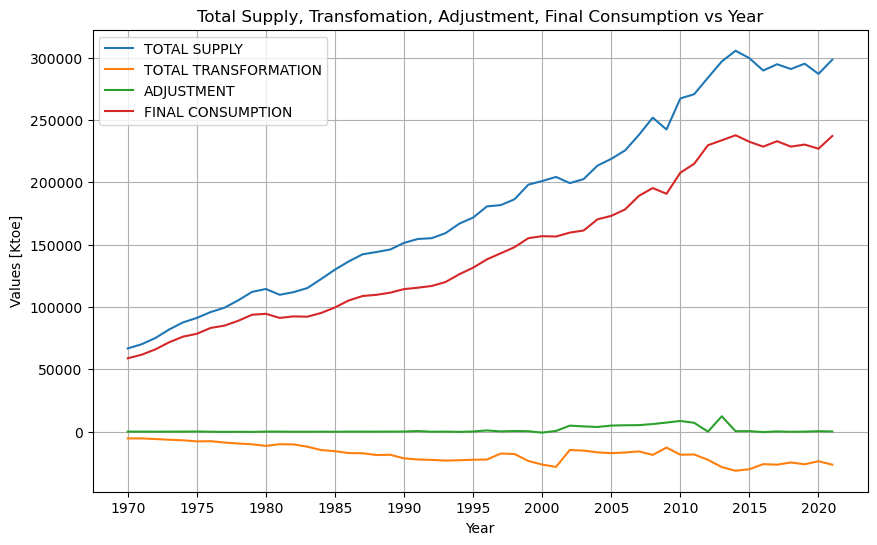

In [5]:
#selected_SECTORS=['TOTAL SUPPLY','TOTAL TRANSFORMATION','ADJUSTMENT','FINAL CONSUMPTION']
# Create a figure and axis
fig, ax = plt.subplots(figsize=( 10,6))

#for k in selected_SECTORS:
 #   df_k=df_concat.loc[df_concat["SECTOR"]==k].drop(columns=["SECTOR"], axis=1)
  #  sns.lineplot(data=df_k, x=df_k.index, y='TOTAL', label=k, ax=ax)

for col in df_summary.columns:
    sns.lineplot(data=df_summary[col], x=df_summary.index, y=df_summary[col], label=col, ax=ax)
        
# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel(f'Values [Ktoe]')
ax.set_title(f'Total Supply, Transfomation, Adjustment, Final Consumption vs Year')
ax.set_xticks(df_summary.index.unique()[::5])

# Show the legend
ax.legend()

# Show the plot
plt.grid(True)
plt.show()




The negative transformation values over  years typically means that more energy was consumed or transformed within the energy system than was produced or input into the system during that specific time period (year). In other words, it indicates an energy deficit or a situation where the energy demands and transformations within the system exceeded the energy available from primary sources or imports.

## I.3 Sankey Diagram

- Sankey diagrams are valuable tools for visualizing energy flows and understanding energy balances in complex systems. 

- Reviewing Sankey diagrams in an energy balance context is crucial for gaining insights into energy flows, identifying inefficiencies, ensuring a balance between supply and demand, and making informed decisions about energy policy, efficiency improvements, and environmental management. They provide a concise and visually intuitive representation of complex energy data, making it easier for stakeholders to understand and act upon energy-related challenges and opportunities.

In [6]:
from collections import defaultdict
import plotly.graph_objects as go

### Define the Plot function

In [7]:
# Defining the Plot function
def Plot(year,db):
    label=db[year]["label"]
    source=db[year]["source"]
    target=db[year]["target"]
    value=db[year]["value"]
    color_nodes=db[year]["color_nodes"]
    color_links=db[year]["color_links"]
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 30,
          thickness = 20,
          line = None, # dict(color = "black", width = 0.5),
          label = label,
          color = color_nodes
        ),
        link = dict(
          source = source, # indices correspond to labels, eg A1, A2, A1, B1, ...
          target = target,
          value = value,
            color=color_links
      ))])

    fig.update_layout(title_text=year, font_size=10)
    fig.show()

#### Preparation the data to plot

In [8]:
# Preparation the data to plot
def Data_Generate(Dict):
    
    Dict_out = {}  # Initialize the output dictionary
    for sheet_name in Dict.keys():

        df=Dict[sheet_name]
        
         # Reset index
        df=df.set_index('SECTOR')

        # Transpose df
        df=df.T

        # Fill NaN values
        df=df.fillna(np.nan)
       

        # define the combinations
        Transformers=['REFINERIES', 'POWER PLANTS', 'SELF-PRODUCERS',
               'GAS PLANTS', 'CHARCOAL PLANTS', 'COKE PLANTS AND BLAST FURNACES',
               'DISTILLERIES', 'OTHER CENTERS']
        Primaries=['OIL','NATURAL GAS','COAL','HYDROENERGY','GEOTHERMAL','NUCLEAR','FIREWOOD','SUGARCANE AND PRODUCTS','OTHER PRIMARY']
        Secondaries=['ELECTRICITY','LPG','GASOLINE/ALCOHOL','KEROSENE/JET FUEL','DIESEL OIL','FUEL OIL','COKE','CHARCOAL','GASES','OTHER SECONDARY']
        Consumptions=['TRANSPORT','INDUSTRIAL','RESIDENTIAL','COMMERCIAL, SERVICES, PUBLIC','AGRICULTURE, FISHING AND MINING','CONSTRUCTION AND OTHERS']

        unique_combinations = []

        # here add secondary combination then type of consumption combination

        for i in Transformers:
            for j in Primaries:
                unique_combinations.append((j, i,abs(df[i][j])))

        for i in Transformers:
            for j in Secondaries:
                unique_combinations.append((i, j,abs(df[i][j])))

        # the final consumption column - Usage column
        for i in Consumptions:
            for j in Primaries+Secondaries:
                unique_combinations.append((j, i,abs(df[i][j])))
                
        label=Transformers+Primaries+Secondaries+Consumptions+Primaries+Secondaries
        
        #colors
        color_Transformers=['blue','yellow','green','orange','grey','grey','pink','cyan']
        color_Primaries=['black','orange','darkgray','lightblue','darkred','red','brown','darkgreen','khaki']
        color_Secondaries=['yellow','lightgreen','plum','plum','plum','grey','grey','grey','grey']
        color_Consumptions=['darkmagenta' for i in range(9)]
        color_nodes=color_Transformers+color_Primaries+color_Secondaries+color_Consumptions+color_Primaries+color_Secondaries
        
        # Rename the sheet_name to contain only year. Sample: "1970 - Brazil"--> "1970"
        sheet_name_new = sheet_name.split(' - ')[0]
    
        _dict=Dict_out[sheet_name_new]={}
        _dict["source"]=[]
        _dict["target"]=[]
        _dict["value"]=[]
        _dict["label"]=label
        _dict["color_nodes"]=color_nodes
        _dict["color_links"]=[]
        


        #Dict_out[sheet_name_new] = data  # Store the data in the dictionary
        for k in unique_combinations:
            _dict["source"].append(label.index(k[0]))
            _dict["target"].append(label.index(k[1]))
            _dict["value"].append(k[2])
            _dict["color_links"].append(color_nodes[label.index(k[0])])
    return Dict_out

In [9]:
db=Data_Generate(Dict)

### Sample plot

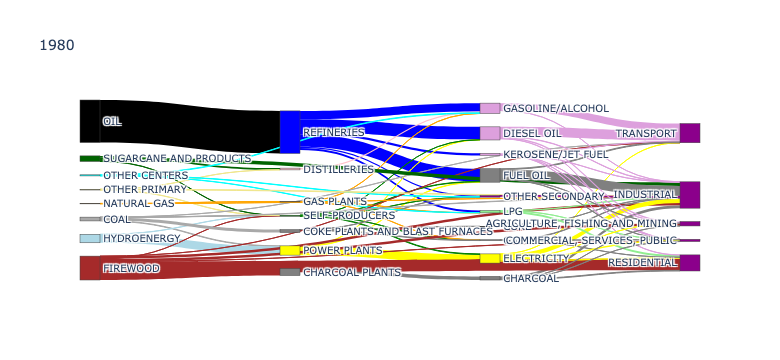

In [10]:
Plot(year='1980',db=db)

## II. DATA ANALYSIS CONSUMPTION



In [11]:
# Show the df final consumption:
df_C=df_concat.copy()

selected_SECTORS_C=['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS',
       'NON-ENERGY CONSUMPTION','FINAL CONSUMPTION']

df_C=df_C[df_C['SECTOR'].isin(selected_SECTORS_C)]
df_C = df_C.groupby(['YEAR','SECTOR'])['TOTAL'].sum().reset_index()
# Pivot the data
df_C = df_C.pivot(index='YEAR', columns='SECTOR', values='TOTAL')

# Reorder the columns in df
df_C = df_C[selected_SECTORS_C]

# Display the resultdf_summary
df_C.head()

SECTOR  TRANSPORT  INDUSTRIAL  RESIDENTIAL  COMMERCIAL, SERVICES, PUBLIC  \
YEAR                                                                       
1970     12661.99    16020.92     22075.66                       1266.80   
1971     13841.87    17454.73     22253.96                       1406.98   
1972     15633.22    19026.99     22440.87                       1570.69   
1973     18328.90    21493.43     22354.13                       1737.84   
1974     20105.68    23257.01     22316.70                       1873.46   

SECTOR  AGRICULTURE, FISHING AND MINING  CONSTRUCTION AND OTHERS  \
YEAR                                                               
1970                            5351.01                     0.00   
1971                            5317.39                     0.00   
1972                            5338.47                     0.00   
1973                            5441.91                     0.00   
1974                            5376.38                     7.15   

SECTOR  NON-ENERGY CONSUMPTION  FINAL CONSUMPTION  
YEAR                                               
1970                   1457.73           58834.12  
1971                   1416.75           61691.69  
1972                   1984.88           65995.12  
1973                   2336.65           71692.86  
1974                   3262.03           76198.40

In [12]:
# df_C_percentages calculate the percentages

df_C_percentages = (df_C.drop(columns=['FINAL CONSUMPTION']).div(df_C['FINAL CONSUMPTION'], axis=0) * 100)
df_C_percentages = df_C_percentages.round(0)

df_C_percentages.columns

Index(['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS', 'NON-ENERGY CONSUMPTION'],
      dtype='object', name='SECTOR')

In [13]:
# Drop the 'FINAL CONSUMPTION' column (if not already dropped) as it is not needed for the stack plot
df_stackplot = df_C.drop(columns=["FINAL CONSUMPTION"])



### a- Show the line_plot:

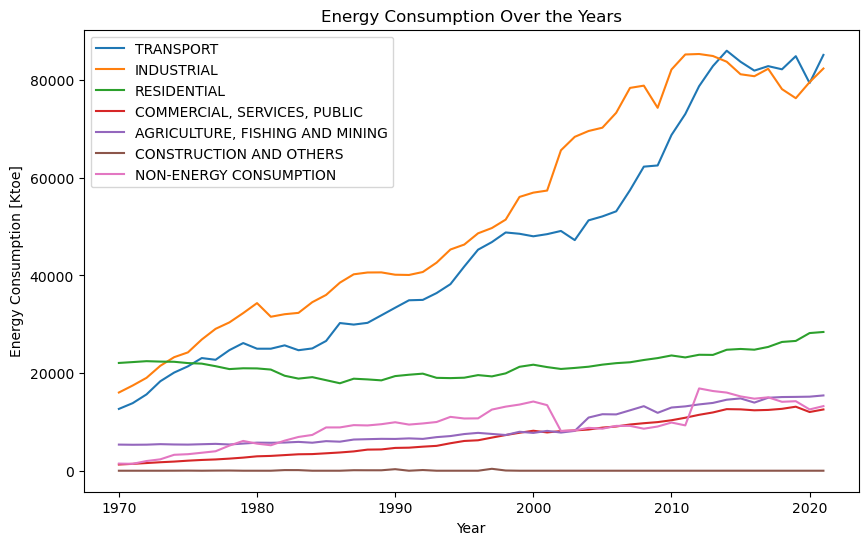

In [14]:
data=df_stackplot.copy()

# Line_Plot:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

data.plot(ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Energy Consumption [Ktoe]')
ax1.set_title('Energy Consumption Over the Years')
ax1.legend(loc='upper left')

plt.show()

### b- Plot both stack plots side by side

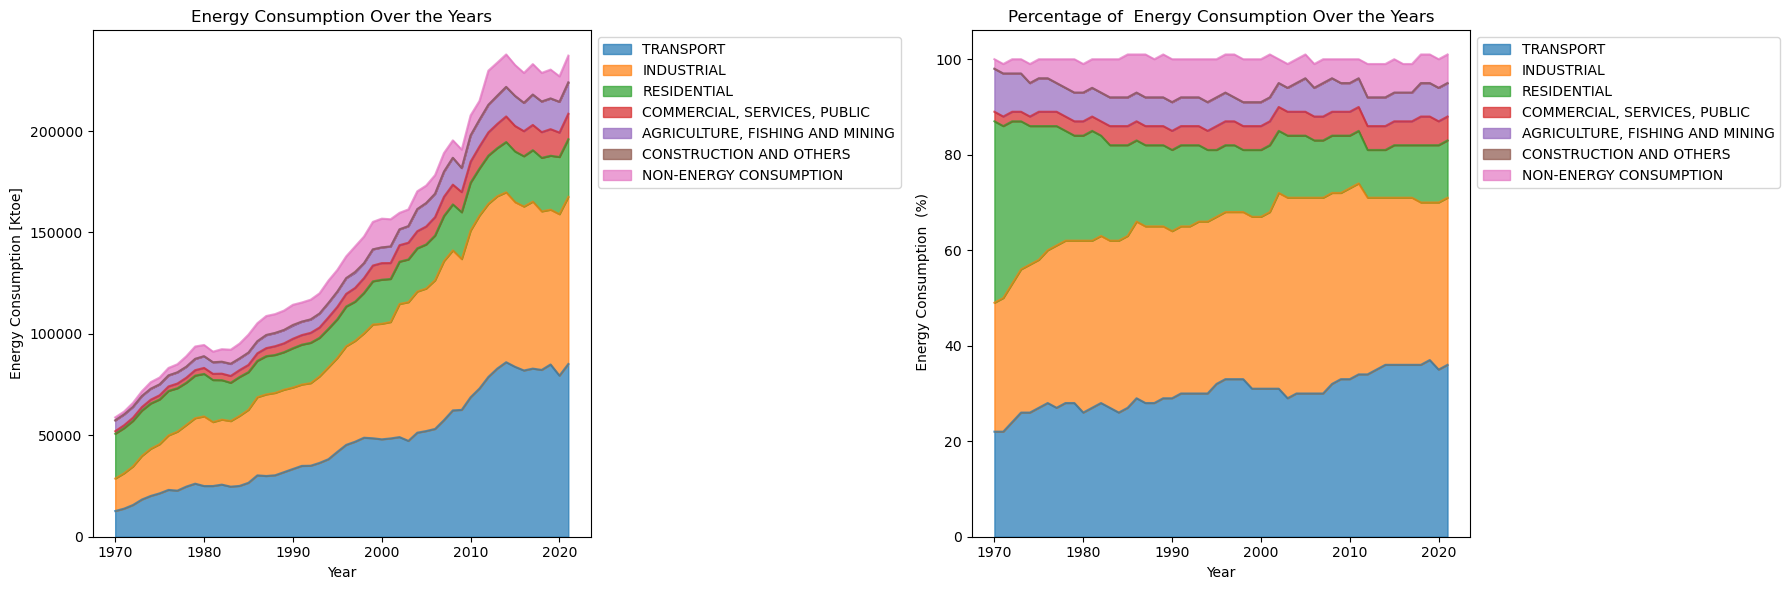

In [15]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 6))

df_stackplot.plot.area(stacked=True, alpha=0.7, ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Energy Consumption [Ktoe]')
ax1.set_title('Energy Consumption Over the Years')
ax1.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

df_C_percentages.plot.area(stacked=True, alpha=0.7, ax=ax2)

ax2.set_xlabel('Year')
ax2.set_ylabel(' Energy Consumption  (%)')
ax2.set_title('Percentage of  Energy Consumption Over the Years')
ax2.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()

### CORRELATION MATRIX

In [16]:
#df_C.index = pd.to_datetime(df_C.index, format='%Y')
df_C.columns

Index(['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS', 'NON-ENERGY CONSUMPTION',
       'FINAL CONSUMPTION'],
      dtype='object', name='SECTOR')

In [17]:

list_corr=df_C.columns.drop(['FINAL CONSUMPTION'])

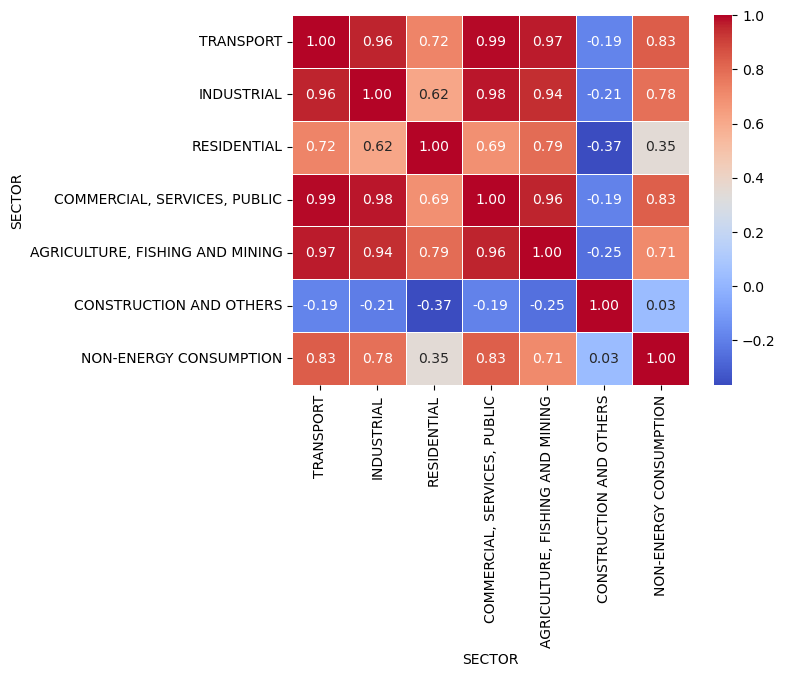

In [18]:

corr_mat = df_C[list_corr].corr()
sns.heatmap(corr_mat,annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.show()

From the correlation matrix, we can observe that the sector **'CONSTRUCTION AND OTHERS'** has a very low correlation with other sectors. We can consider dropping it if necessary.

In [19]:
df_C.columns

Index(['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS', 'NON-ENERGY CONSUMPTION',
       'FINAL CONSUMPTION'],
      dtype='object', name='SECTOR')

## Scaled data

### MinMaxScaler
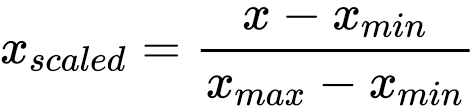

In [20]:
df_C.head()

SECTOR  TRANSPORT  INDUSTRIAL  RESIDENTIAL  COMMERCIAL, SERVICES, PUBLIC  \
YEAR                                                                       
1970     12661.99    16020.92     22075.66                       1266.80   
1971     13841.87    17454.73     22253.96                       1406.98   
1972     15633.22    19026.99     22440.87                       1570.69   
1973     18328.90    21493.43     22354.13                       1737.84   
1974     20105.68    23257.01     22316.70                       1873.46   

SECTOR  AGRICULTURE, FISHING AND MINING  CONSTRUCTION AND OTHERS  \
YEAR                                                               
1970                            5351.01                     0.00   
1971                            5317.39                     0.00   
1972                            5338.47                     0.00   
1973                            5441.91                     0.00   
1974                            5376.38                     7.15   

SECTOR  NON-ENERGY CONSUMPTION  FINAL CONSUMPTION  
YEAR                                               
1970                   1457.73           58834.12  
1971                   1416.75           61691.69  
1972                   1984.88           65995.12  
1973                   2336.65           71692.86  
1974                   3262.03           76198.40

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_C)
scaled_df = pd.DataFrame(scaled_data, columns=df_C.columns)
scaled_df.set_index(df_C.index, inplace=True)

In [22]:
scaled_df.head()

SECTOR  TRANSPORT  INDUSTRIAL  RESIDENTIAL  COMMERCIAL, SERVICES, PUBLIC  \
YEAR                                                                       
1970     0.000000    0.000000     0.395950                      0.000000   
1971     0.016081    0.020678     0.412922                      0.011833   
1972     0.040495    0.043352     0.430713                      0.025652   
1973     0.077235    0.078921     0.422457                      0.039761   
1974     0.101450    0.104355     0.418894                      0.051209   

SECTOR  AGRICULTURE, FISHING AND MINING  CONSTRUCTION AND OTHERS  \
YEAR                                                               
1970                           0.003327                 0.000000   
1971                           0.000000                 0.000000   
1972                           0.002086                 0.000000   
1973                           0.012323                 0.000000   
1974                           0.005838                 0.018204   

SECTOR  NON-ENERGY CONSUMPTION  FINAL CONSUMPTION  
YEAR                                               
1970                  0.002654           0.000000  
1971                  0.000000           0.015970  
1972                  0.036794           0.040021  
1973                  0.059575           0.071865  
1974                  0.119505           0.097046

### Running ARIMA

We apply the ARIMA model to all sectors, but first, we need to perform some checks to select the best parameters **(p, d, q)**

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score

In [24]:

# Split data into train and test sets 
train_size = int(len(df_C) * 0.80)

# Separate the data into 2 parts: training and validation
data_tr= df_C.iloc[:train_size]
data_val=df_C.iloc[train_size:]


In [25]:
data_tr.tail()

SECTOR  TRANSPORT  INDUSTRIAL  RESIDENTIAL  COMMERCIAL, SERVICES, PUBLIC  \
YEAR                                                                       
2006     53138.32    73324.16     22034.81                       9060.76   
2007     57478.13    78418.45     22216.18                       9467.70   
2008     62289.25    78879.36     22681.60                       9732.39   
2009     62530.21    74338.79     23071.27                       9958.74   
2010     68765.74    82179.55     23610.56                      10339.55   

SECTOR  AGRICULTURE, FISHING AND MINING  CONSTRUCTION AND OTHERS  \
YEAR                                                               
2006                           11535.36                      0.0   
2007                           12375.19                      0.0   
2008                           13222.55                      0.0   
2009                           11860.91                      0.0   
2010                           12945.44                      0.0   

SECTOR  NON-ENERGY CONSUMPTION  FINAL CONSUMPTION  
YEAR                                               
2006                   9183.32          178276.74  
2007                   9185.24          189140.88  
2008                   8607.79          195412.94  
2009                   9054.90          190814.83  
2010                   9871.64          207712.48

In [26]:
data_val.head()

SECTOR  TRANSPORT  INDUSTRIAL  RESIDENTIAL  COMMERCIAL, SERVICES, PUBLIC  \
YEAR                                                                       
2011     73066.20    85265.02     23209.47                      10853.97   
2012     78767.15    85362.25     23752.93                      11452.52   
2013     82886.93    84952.58     23723.46                      11936.18   
2014     86034.69    83781.40     24778.75                      12615.20   
2015     83773.75    81213.58     24943.13                      12570.99   

SECTOR  AGRICULTURE, FISHING AND MINING  CONSTRUCTION AND OTHERS  \
YEAR                                                               
2011                           13179.01                      0.0   
2012                           13581.46                      0.0   
2013                           13888.80                      0.0   
2014                           14546.00                      0.0   
2015                           14811.58                      0.0   

SECTOR  NON-ENERGY CONSUMPTION  FINAL CONSUMPTION  
YEAR                                               
2011                   9285.87          214859.53  
2012                  16857.76          229774.08  
2013                  16325.29          233713.25  
2014                  16007.09          237763.12  
2015                  15224.03          232537.06

In [27]:
df_C.columns

Index(['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS', 'NON-ENERGY CONSUMPTION',
       'FINAL CONSUMPTION'],
      dtype='object', name='SECTOR')

### Prepare Functions

In [245]:
import warnings

# Suppress specific warning by category (e.g., FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error 

def MAPE(actual,forecast):
      # Ensure both DataFrames have the same shape
    if actual.shape != forecast.shape:
        raise ValueError("Input data shapes must match.")

    # Replace zero values in y_true with a small non-zero value to avoid division by zero
    actual = actual.replace(0, 1e-10)

    # Calculate the mean of absolute percentage errors 
    mape= round(abs((actual.to_numpy() - forecast.to_numpy()) / actual.to_numpy()).mean()*100,2)

    return mape

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

## II.1. Sample sector (TRANSPORT)- Mathematic background of ARIMA model

In [388]:
sector='TRANSPORT'
df_transport=df_C[[sector]]
df_transport.head()

SECTOR  TRANSPORT
YEAR             
1970     12661.99
1971     13841.87
1972     15633.22
1973     18328.90
1974     20105.68

In [389]:
# Train and Test data
df_tr=df_transport.iloc[:train_size]#train[['TRANSPORT']]
df_val=df_transport.iloc[train_size:]

### check stationary of the time series

In [390]:
test_stationarity(df_tr)

Results of Dickey-Fuller Test:
Test Statistic                  1.419910
p-value                         0.997203
#Lags Used                      0.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


In this case, the p-value is almost  $1$, we can conclude that the data is not stationary.

**The next step, The Partial Autocorrelation Function (PACF) is visualized.**

Showing the PACF is important in time series analysis because it helps in model selection, order determination, diagnosing the adequacy of a chosen model, and understanding the underlying autocorrelation structure of the data. 

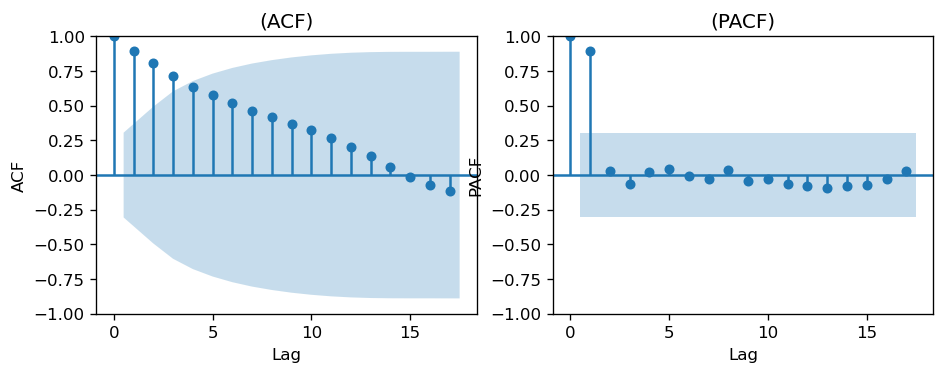

In [399]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)

# Plot ACF
plot_acf(df_tr, ax=axes[0])
axes[0].set_title('(ACF)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')

# Plot PACF
plot_pacf(df_tr, ax=axes[1], method='ywm')
axes[1].set_title('(PACF)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')

plt.show()


### How to find the order of differencing (d) in ARIMA model

**Transform to stationary: differencing**

The value of **d** can be determined by finding the minimum number of differencing steps required to make the time series stationary.

In some cases, if the autocorrelations (ACF) are positive for many number of lags (10 or more), then the series needs further differencing.


<AxesSubplot:xlabel='YEAR'>

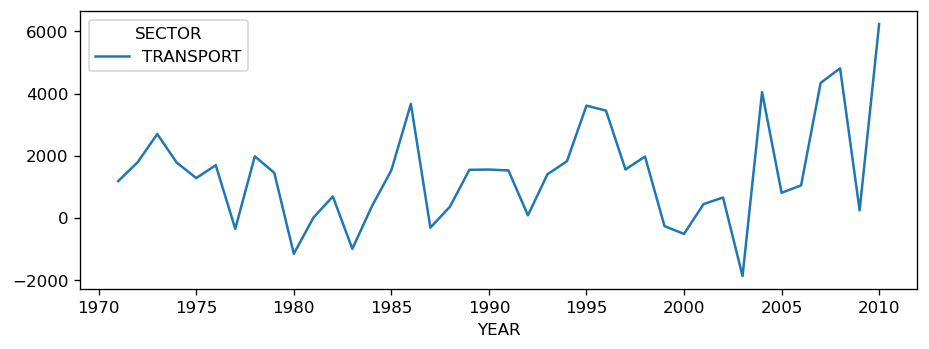

In [400]:
train_diff = df_tr.diff().dropna()
train_diff.plot()

In [401]:
#Test with diffencing data:
test_stationarity(train_diff)


Results of Dickey-Fuller Test:
Test Statistic                 -2.452644
p-value                         0.127426
#Lags Used                      4.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


p-value in the first differential is still greater than 0.05 so the second differential may need.

In [406]:
# Check the second differential:
train_diff_2=df_tr.diff().diff().dropna()
#train_diff_2.plot()


In [408]:
test_stationarity(train_diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -8.368694e+00
p-value                        2.698869e-13
#Lags Used                     1.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (1%)           -3.620918e+00
Critical Value (5%)           -2.943539e+00
Critical Value (10%)          -2.610400e+00
dtype: float64


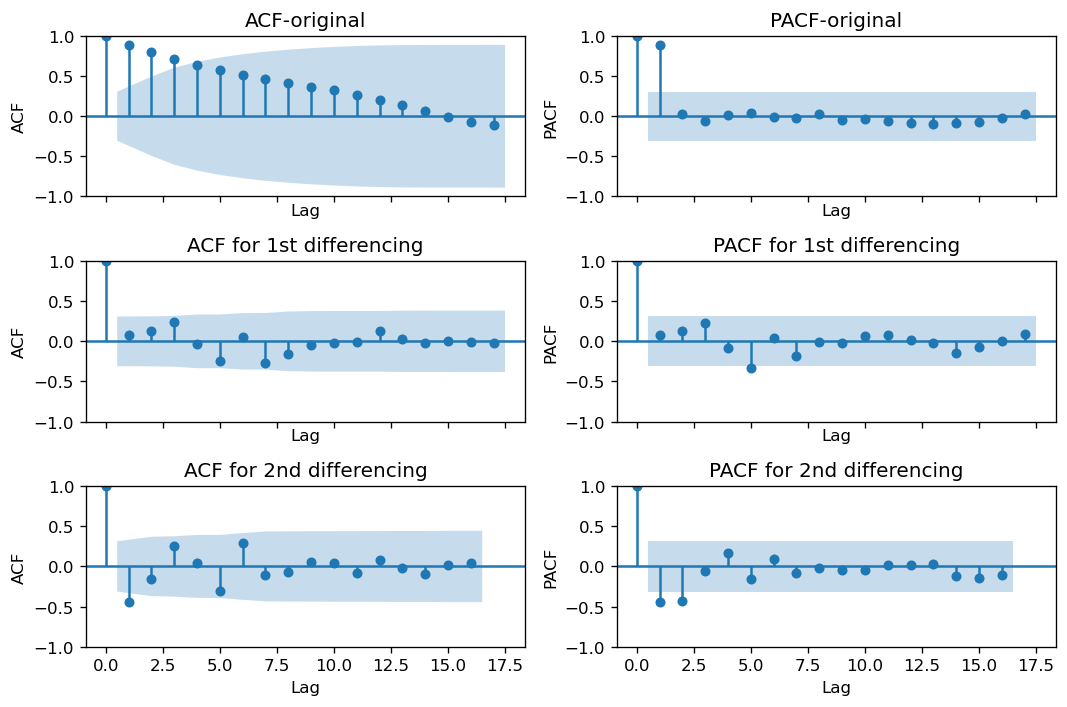

In [409]:

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize': (9, 6), 'figure.dpi': 120})

fig, axes = plt.subplots(3, 2, sharex=True)

# Plot ACF for original data
plot_acf(df_tr, ax=axes[0, 0])
axes[0, 0].set_title('ACF-original')
axes[0, 0].set_xlabel('Lag')
axes[0, 0].set_ylabel('ACF')

# Plot PACF for train
plot_pacf(df_tr, ax=axes[0, 1], method='ywm')
axes[0, 1].set_title('PACF-original')
axes[0, 1].set_xlabel('Lag')
axes[0, 1].set_ylabel('PACF')


# Plot ACF for train_diff
plot_acf(train_diff, ax=axes[1, 0])
axes[1, 0].set_title('ACF for 1st differencing')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('ACF')

# Plot PACF for train_diff
plot_pacf(train_diff, ax=axes[1, 1], method='ywm')
axes[1, 1].set_title('PACF for 1st differencing')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('PACF')

# Plot ACF for train_diff_2
plot_acf(train_diff_2, ax=axes[2, 0])
axes[2, 0].set_title('ACF for 2nd differencing')
axes[2, 0].set_xlabel('Lag')
axes[2, 0].set_ylabel('ACF')

# Plot PACF for train_diff_2
plot_pacf(train_diff_2, ax=axes[2, 1], method='ywm')
axes[2, 1].set_title('PACF for 2nd differencing')
axes[2, 1].set_xlabel('Lag')
axes[2, 1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

In the second differential, the p-value is small enough to conclude that the series is well stationary  but on looking at the autocorrelation (ACF) plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

In conclusion, we may take $d=1$ (or $2$)

We can observe from the above figures that the best combinations for **(p,d,q)** can be:
**(2,1,1),(2,2,1)**  

In [412]:
df_transport.index = pd.to_datetime(df_transport.index, format='%Y')
df_tr.index = pd.to_datetime(df_tr.index, format='%Y')
df_val.index = pd.to_datetime(df_val.index, format='%Y')
df_val.head(3)

SECTOR      TRANSPORT
YEAR                 
2011-01-01   73066.20
2012-01-01   78767.15
2013-01-01   82886.93

                               SARIMAX Results                                
Dep. Variable:              TRANSPORT   No. Observations:                   41
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -355.784
Date:                Thu, 07 Sep 2023   AIC                            719.567
Time:                        00:55:33   BIC                            726.323
Sample:                    01-01-1970   HQIC                           722.010
                         - 01-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7101      0.289      2.458      0.014       0.144       1.276
ar.L2          0.1634      0.168      0.973      0.330      -0.166       0.493
ma.L1         -0.6274      0.291     -2.156      0.0

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Text(0.5, 1.0, 'TRANSPORT-MAPE=5.05')

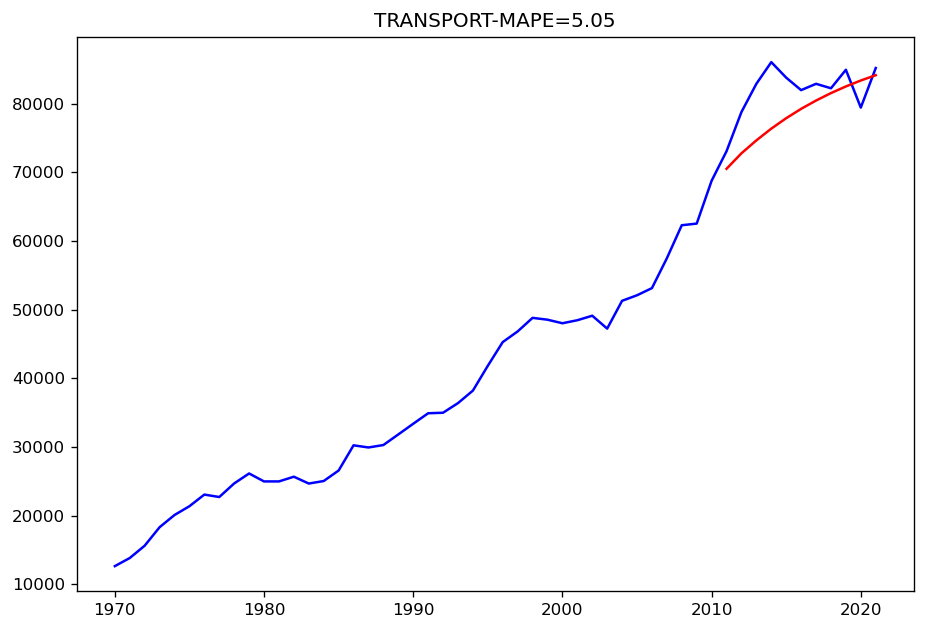

In [413]:
# check with order=(1,1,1)

#fit the arima model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_tr, order=(2,1,1)) #this combination is the best
model_fit = model.fit()
print(model_fit.summary())

# prediction

forecast_val = model_fit.predict(start=df_val.index[0], end=df_val.index[-1])

# Create a Pandas DataFrame with the forecasted values and set the index
df_forecast = pd.DataFrame(data=forecast_val, index=df_val.index)

#mape=round(mean_absolute_percentage_error(df_val, df_forecast),2)
mape=MAPE(df_val, df_forecast)
# Plot

plt.plot(df_transport, "b", label= "Actual")
plt.plot(df_forecast, "r", label="Forecast")
plt.title(f'TRANSPORT-MAPE={mape}')


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



Text(0.5, 1.0, 'TRANSPORT-MAPE=14.6')

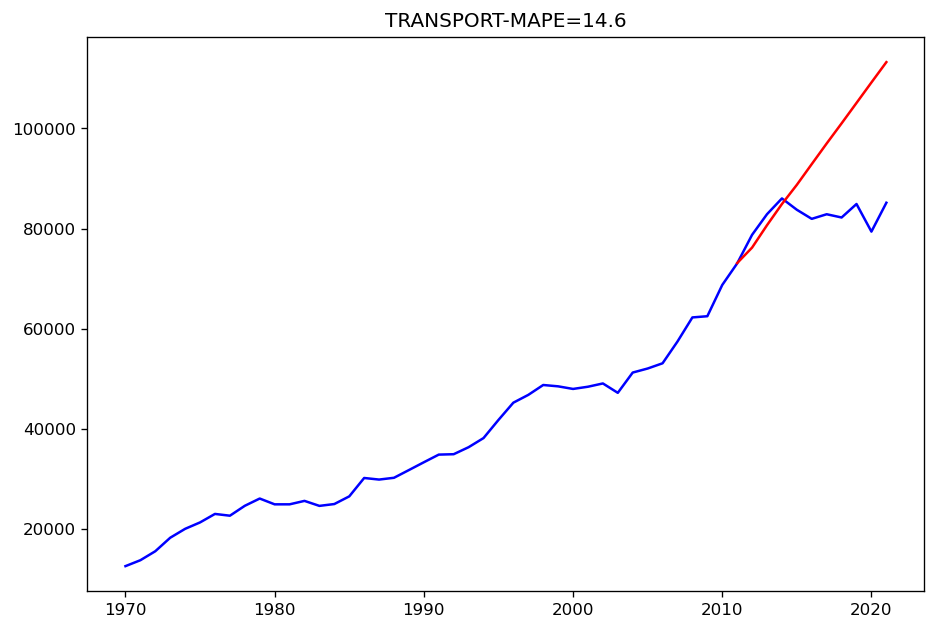

In [414]:
# check with order=(2,2,1)

#fit the arima model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_tr, order=(2,2,1)) 
model_fit = model.fit()
#print(model_fit.summary())
# Prediction

# prediction

forecast_val = model_fit.predict(start=df_val.index[0], end=df_val.index[-1])

# Create a Pandas DataFrame with the forecasted values and set the index
df_forecast = pd.DataFrame(data=forecast_val, index=df_val.index)
mape=MAPE(df_val, df_forecast)
# Plot

plt.plot(df_transport, "b", label= "Actual")
plt.plot(df_forecast, "r", label="Forecast")
plt.title(f"TRANSPORT-MAPE={mape}")



We can observe that $(p,d,q)=(2,1,1)$ returns the better result with  MAPE=5.05% 

### Future forecast (20 more years)

                               SARIMAX Results                                
Dep. Variable:              TRANSPORT   No. Observations:                   52
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -465.506
Date:                Thu, 07 Sep 2023   AIC                            939.011
Time:                        01:58:15   BIC                            946.738
Sample:                    01-01-1970   HQIC                           941.964
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4607      0.418      1.102      0.270      -0.359       1.280
ar.L2          0.2929      0.208      1.410      0.159      -0.114       0.700
ma.L1         -0.4135      0.431     -0.959      0.3

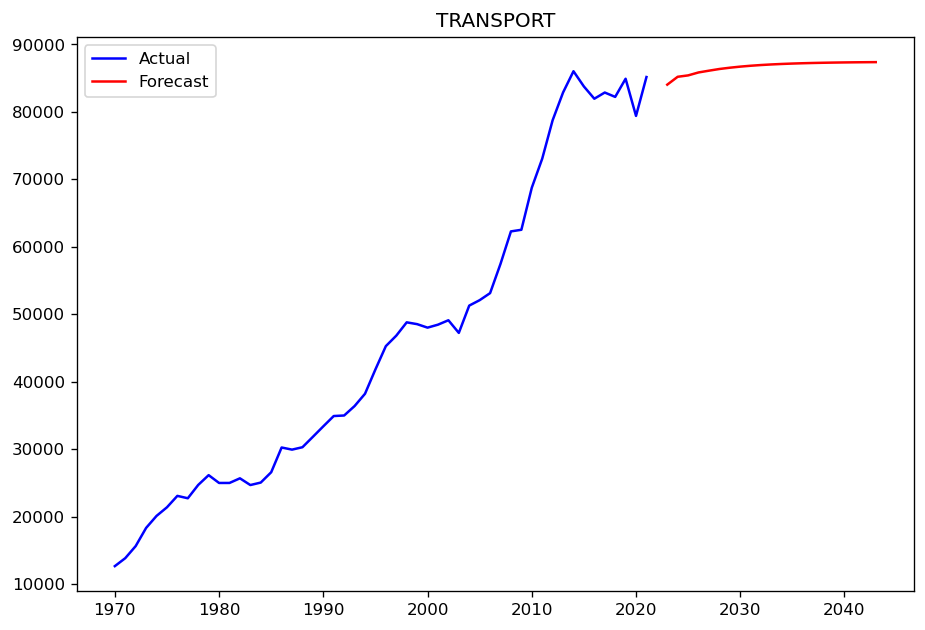

In [454]:
model = ARIMA(df_transport, order=(2,1,1)) #this combination is the best
model_fit = model.fit()
print(model_fit.summary())
warnings.filterwarnings("ignore")
# Specify the number of future steps to forecast
periods = 20  # Adjust as needed
# Specify the start date
start_date = pd.to_datetime('2022-01-01')

# Prediction for future time points
data_pred = model_fit.predict(start=start_date, end=start_date+ pd.DateOffset(years=periods))


# Create a date range for the forecasted period
forecast_index = date_range = pd.date_range(start=start_date, periods=periods+1, freq='A')

# Create a Pandas DataFrame with the forecasted values and set the index
df_forecast = pd.DataFrame(data=list(data_pred), index=forecast_index)

# Plot
plt.plot(df_transport, "b", label="Actual")
plt.plot(df_forecast, "r", label="Forecast")

plt.title("TRANSPORT")
plt.legend()
plt.show()

df_pred_TRANSPORT=df_forecast
df_pred_TRANSPORT.to_excel("pred_TRANSPORT.xlsx")


In [455]:
df_pred_TRANSPORT

0
2022-12-31  84045.301855
2023-12-31  85212.295680
2024-12-31  85418.629745
2025-12-31  85855.549938
2026-12-31  86117.271031
2027-12-31  86365.832878
2028-12-31  86557.008462
2029-12-31  86717.892949
2030-12-31  86848.012060
2031-12-31  86955.084777
2032-12-31  87042.528065
2033-12-31  87114.177274
2034-12-31  87172.800228
2035-12-31  87220.795538
2036-12-31  87260.078999
2037-12-31  87292.235829
2038-12-31  87318.557516
2039-12-31  87340.103398
2040-12-31  87357.739818
2041-12-31  87372.176206
2042-12-31  87383.993165

## How to do Auto Arima Forecast in Python

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [427]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df= df_transport

model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=927.002, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=945.384, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=930.512, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=925.305, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=943.447, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=927.331, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=929.064, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=923.539, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=925.227, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=925.295, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=928.533, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=927.456, Time=0.03 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.413 seconds
                               SARIMAX Results                                
Dep. Variable:       

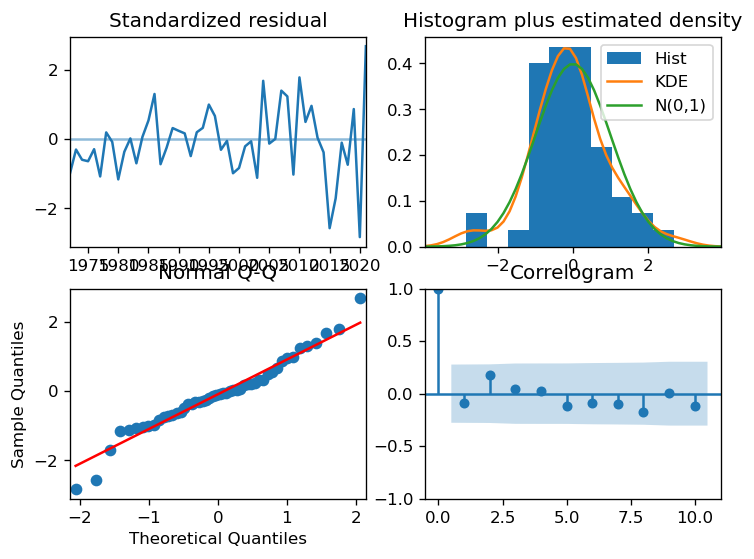

In [428]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

                               SARIMAX Results                                
Dep. Variable:              TRANSPORT   No. Observations:                   41
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -347.842
Date:                Thu, 07 Sep 2023   AIC                            699.684
Time:                        01:01:25   BIC                            703.011
Sample:                    01-01-1970   HQIC                           700.878
                         - 01-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6470      0.126     -5.149      0.000      -0.893      -0.401
sigma2      3.183e+06   7.57e+05      4.206      0.000     1.7e+06    4.67e+06
Ljung-Box (L1) (Q):                   0.47   Jarque-

Text(0.5, 1.0, 'TRANSPORT-MAPE=12.22')

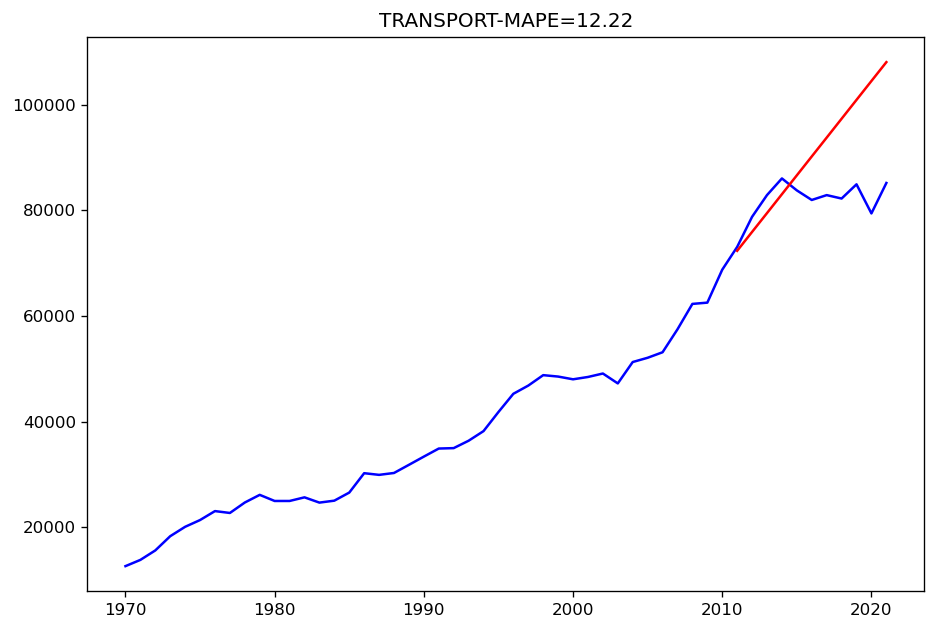

In [429]:
# check with Best model from auto_arima order=(0,2,1)

#fit the arima model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_tr, order=(0,2,1)) 
model_fit = model.fit()
print(model_fit.summary())

# prediction

forecast_val = model_fit.predict(start=df_val.index[0], end=df_val.index[-1])

# Create a Pandas DataFrame with the forecasted values and set the index
df_forecast = pd.DataFrame(data=forecast_val, index=df_val.index)

#mape=round(mean_absolute_percentage_error(df_val, df_forecast),2)
mape=MAPE(df_val, df_forecast)
# Plot

plt.plot(df_transport, "b", label= "Actual")
plt.plot(df_forecast, "r", label="Forecast")
plt.title(f'TRANSPORT-MAPE={mape}')

## II.2. Generate for all sectors

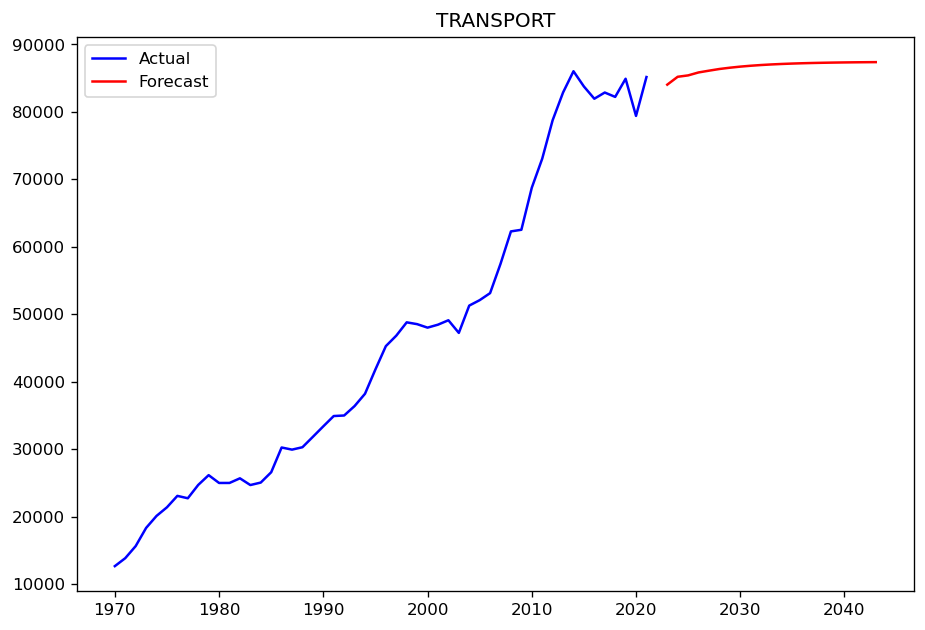

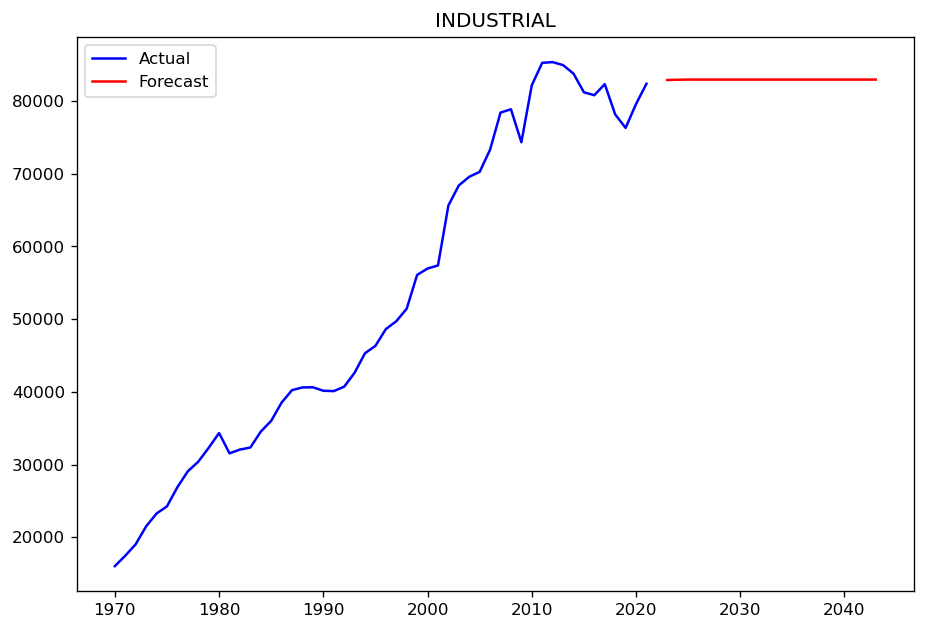

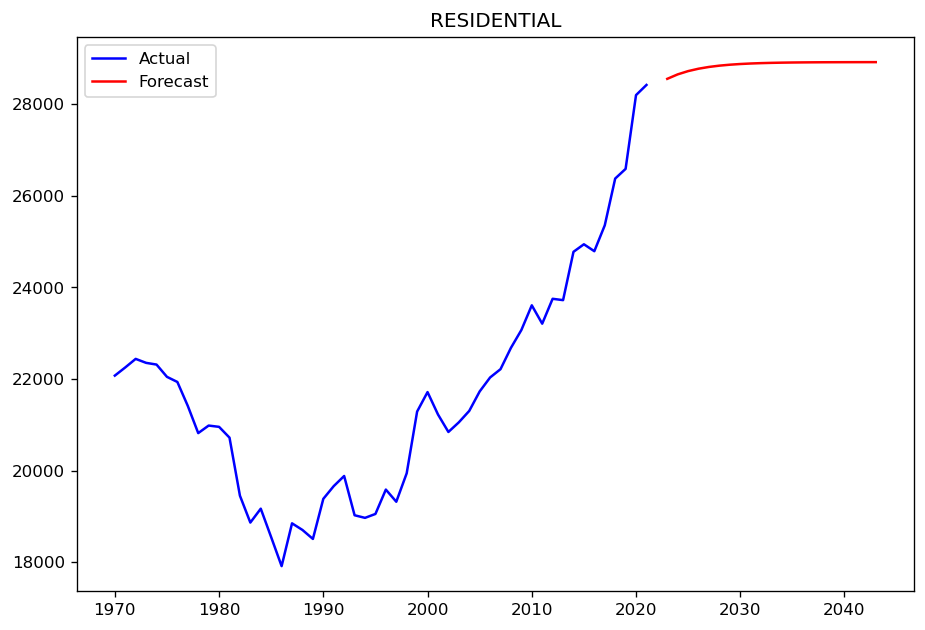

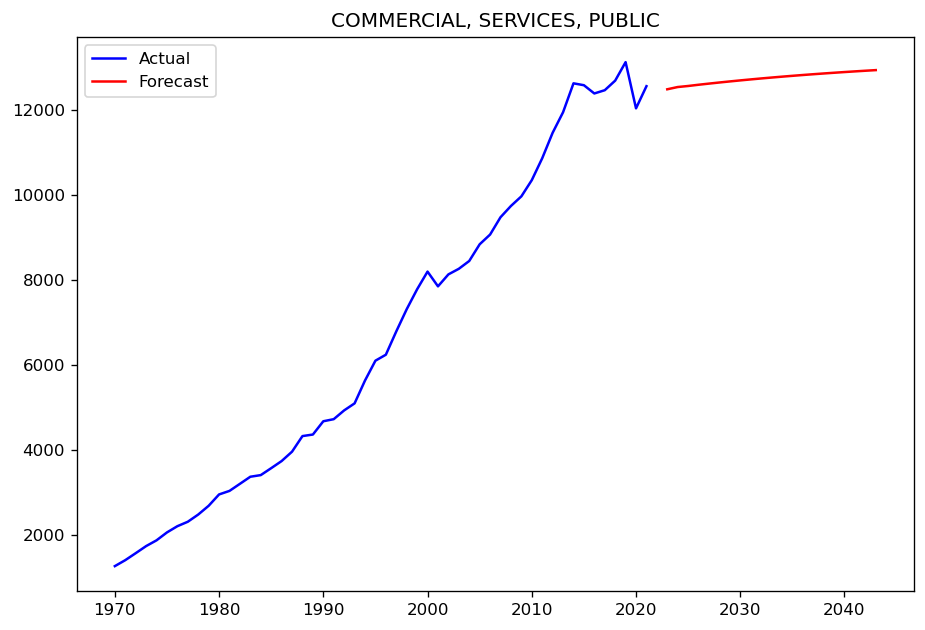

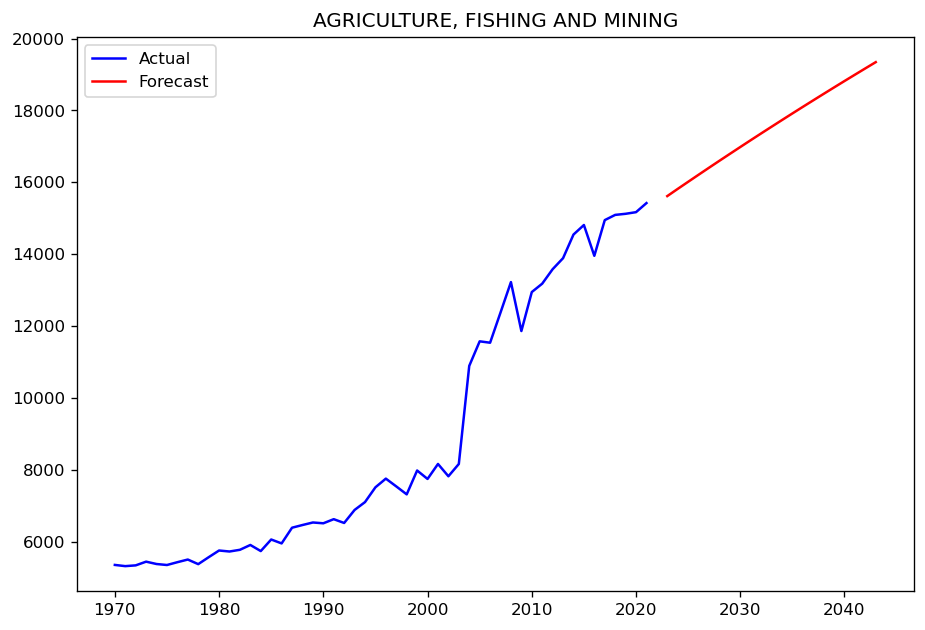

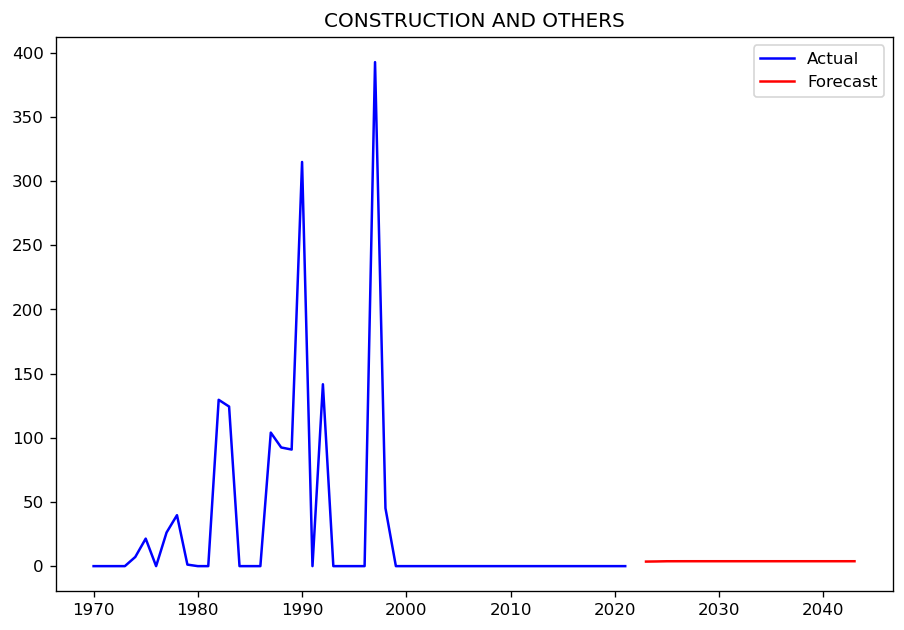

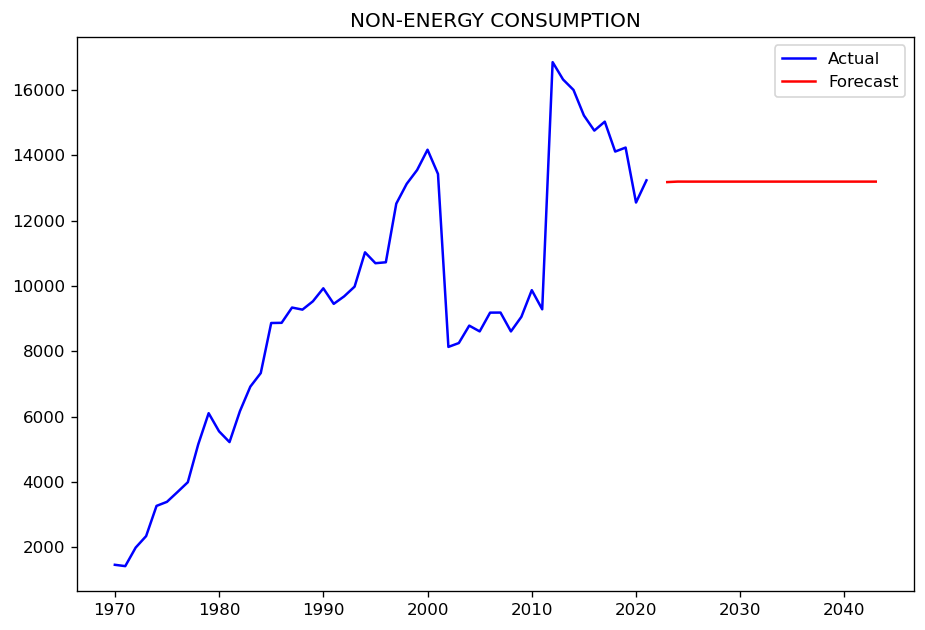

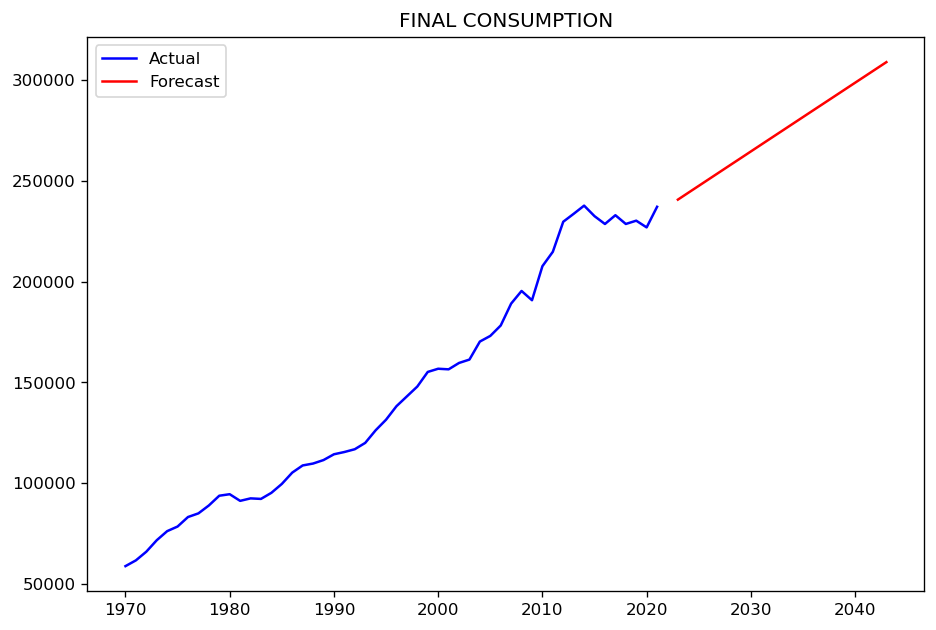

In [482]:

df_C_pred=pd.DataFrame()
for s in df_C.columns:
    
    
    # prepare data: 
    df_sector= df_C[[s]]
    df_sector.index = pd.to_datetime(df_sector.index, format='%Y')
    
    # Build model ARIMA with order=(1,1,1) or (2,1,1)
    model = ARIMA(df_sector, order=(2,1,1)) #this combination is the best 
    model_fit = model.fit()
    
    # Specify the number of future steps to forecast
    periods = 20  # Adjust as needed
    # Specify the start date
    start_date = pd.to_datetime('2022-01-01')

    # Prediction for future time points
    data_pred = model_fit.predict(start=start_date, end=start_date+ pd.DateOffset(years=periods))

    # Create a date range for the forecasted period
    forecast_index = pd.date_range(start=start_date, periods=periods+1, freq='Y')

    # Create a Pandas DataFrame with the forecasted values and set the index
    df_forecast = pd.DataFrame(data=list(data_pred), index=forecast_index, columns=[s])

    # Plot
    plt.plot(df_sector, "b", label="Actual")
    plt.plot(df_forecast, "r", label="Forecast")

    plt.title(f"{s}")
    plt.legend()
    plt.show()
    
    #Concatenate df
    df_C_pred=pd.concat([df_C_pred,df_forecast],axis=1)
# Round the values of each column in the dataframe with 2 decimals
df_C_pred = df_C_pred.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)  
df_C_pred.index=df_C_pred.index.year
# Save the df_forecast to excel
file_name='df_C_pred.xlsx'
df_C_pred.to_excel(file_name)

In [483]:
df_C_2042=pd.concat([df_C, df_C_pred], axis=0)

In [484]:
df_C_2042.index=df_C_2042.index.astype(int)

<AxesSubplot:>

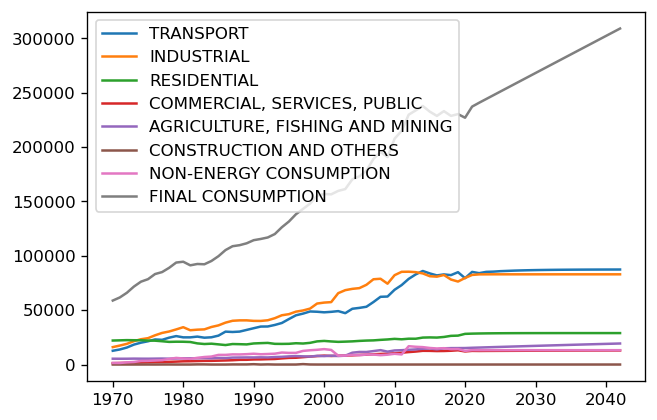

In [489]:
df_C_2042.plot(figsize=(6, 4))

In [486]:
val_2040=df_C_2042.loc[2040,'FINAL CONSUMPTION']


In [487]:
val_2040

302174.97